In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.interactive(False)
%matplotlib inline
import random
random.seed(42)

# COMPAS

In [2]:
#https://www.kaggle.com/wenruliu/adult-income-dataset
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
df.sample(5).T


,2056,6263,6546,4538,3599
id,3139,9554,9981,6935,5497
name,jose llerena,scott konija,david penso,zachary moore,douglas duarte
first,jose,scott,david,zachary,douglas
last,llerena,konija,penso,moore,duarte
compas_screening_date,2013-12-07,2013-08-26,2014-06-13,2013-01-27,2013-03-11
sex,Male,Male,Male,Male,Male
dob,1990-09-03,1971-11-12,1995-01-23,1994-08-13,1972-12-13
age,25,44,21,21,43
age_cat,25 - 45,25 - 45,Less than 25,Less than 25,25 - 45
race,Hispanic,Caucasian,African-American,Caucasian,Hispanic


In [3]:
df['two_year_recid'].value_counts(normalize=True)

0    0.549348
1    0.450652
Name: two_year_recid, dtype: float64

In [4]:
len(df)

7214

In [5]:
# removing bad records - based on:
# https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
'''

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:

If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
'''  

"\n\nHowever not all of the rows are useable for the first round of analysis.\n\nThere are a number of reasons remove rows because of missing data:\n\nIf the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.\nWe coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.\nIn a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).\nWe filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.\n"

In [6]:
#df = df[
condition = (df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30) & (df['is_recid'] != -1) & (df['c_charge_degree'] != 0) & (df['score_text'] != 'N/A') 

df = df[condition]
len(df)

6172

0        0.984468
1       10.077384
2        1.085764
5        1.318495
6        6.298681
          ...    
7209     1.903391
7210     1.868032
7211     1.084549
7212     1.175023
7213     1.960208
Name: length_of_stay, Length: 6172, dtype: float64

<AxesSubplot:xlabel='decile_score', ylabel='length_of_stay'>

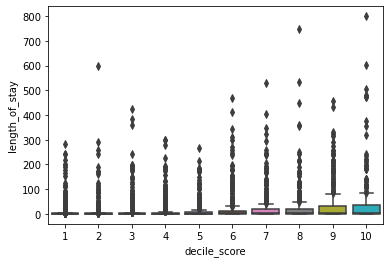

In [7]:
df['length_of_stay'] = (pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])) /  np.timedelta64(1,'D')
df['length_of_stay'] 
sb.boxplot(y=df['length_of_stay'], x=df['decile_score'])

<AxesSubplot:xlabel='decile_score', ylabel='race'>

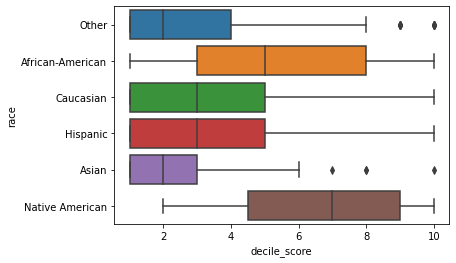

In [8]:
sb.boxplot(y=df['race'], x=df['decile_score'])

<AxesSubplot:xlabel='decile_score', ylabel='age_cat'>

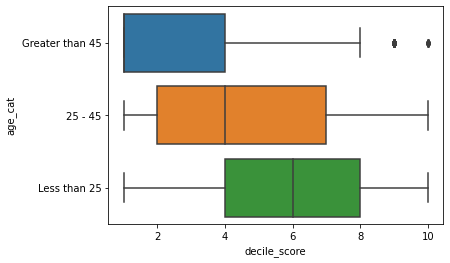

In [9]:
sb.boxplot(y=df['age_cat'], x=df['decile_score'])

<AxesSubplot:xlabel='decile_score', ylabel='sex'>

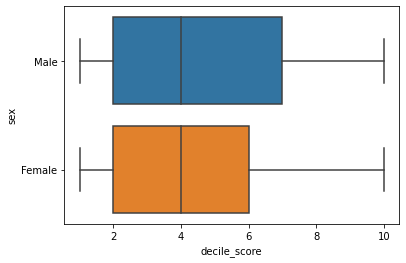

In [10]:
sb.boxplot(y=df['sex'], x=df['decile_score'])

In [11]:
pd.crosstab(df['race'], df['decile_score'])

decile_score,1,2,3,4,5,6,7,8,9,10
race,,,,,,,,,,
African-American,365,346,298,337,323,318,343,301,317,227
Asian,15,4,5,0,1,2,1,2,0,1
Caucasian,605,321,238,243,200,160,113,96,77,50
Hispanic,159,89,73,47,39,27,28,14,17,16
Native American,0,2,1,0,0,2,2,0,2,2
Other,142,60,32,39,19,20,9,7,7,8


In [14]:
df['two_year_recid'].value_counts(normalize=True)

0    0.54488
1    0.45512
Name: two_year_recid, dtype: float64

# Remove fair features

In [15]:
target = df['two_year_recid']
list_of_unfair_features = ['age_cat', 'race', 'sex']
df = df[list_of_unfair_features]
df.sample(10)

,age_cat,race,sex
2696,Greater than 45,Caucasian,Female
5647,Greater than 45,Caucasian,Male
3384,25 - 45,Hispanic,Male
681,25 - 45,African-American,Male
5553,Greater than 45,Caucasian,Male
6796,Less than 25,African-American,Male
7064,Greater than 45,Caucasian,Male
3878,25 - 45,African-American,Male
3994,25 - 45,African-American,Male
731,25 - 45,African-American,Female


In [16]:
df.describe(include='all').T

,count,unique,top,freq
age_cat,6172,3,25 - 45,3532
race,6172,6,African-American,3175
sex,6172,2,Male,4997


In [17]:
# normalized 
df = pd.get_dummies(df, columns=list_of_unfair_features ,prefix='f')
df

,f_25 - 45,f_Greater than 45,f_Less than 25,f_African-American,f_Asian,f_Caucasian,f_Hispanic,f_Native American,f_Other,f_Female,f_Male
0,0,1,0,0,0,0,0,0,1,0,1
1,1,0,0,1,0,0,0,0,0,0,1
2,0,0,1,1,0,0,0,0,0,0,1
5,1,0,0,0,0,0,0,0,1,0,1
6,1,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
7209,0,0,1,1,0,0,0,0,0,0,1
7210,0,0,1,1,0,0,0,0,0,0,1
7211,0,1,0,0,0,0,0,0,1,0,1
7212,1,0,0,1,0,0,0,0,0,1,0


# LR

In [18]:
%%time
lr_classifier = LogisticRegression(max_iter=1000, n_jobs=1) #class_weight='balanced',
scores = cross_val_score(lr_classifier, df, target, cv=10)
scores.mean()


Wall time: 188 ms


0.5983462101304463

# DT

In [19]:
tree_classifier = tree.DecisionTreeClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3)
scores = cross_val_score(tree_classifier, df, target, cv=10)
scores.mean()


0.6028787902629384